# Relevance Vector Machine 

The relevance vector machine is a probabilisic linear model in which the prior weights are taken to be normally distibuted with mean zero and a diagonal matrix.

$$
\begin{align}
    p({\bf w} | {\bf t}, {\bf \alpha}, {\bf \beta}) &\propto p({\bf w}| {\bf \alpha}) p({\bf t}| y({\bf x}), \beta)\\
    &= \mathcal{N}({\bf w}|{\bf 0}, A) \prod_{n=1}^N\mathcal{N}(t_n|y(x_n), \beta^{-1})
\end{align}
$$

Where $A = \text{diag}(\alpha_1, \ldots, \alpha_M)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn, seed, uniform
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import multivariate_normal

In [2]:
from pymc3.gp.util import plot_gp_dist

In [3]:
%config InlineBackend.figure_format = "retina"
np.set_printoptions(precision=3, suppress=True)

## The Test Data

In [4]:
nobs = 50
seed(3141)
X = np.linspace(0, 1, nobs) + uniform(0, 0.01, nobs)
y = np.sin(2 * np.pi * X) + randn(nobs) * 0.3

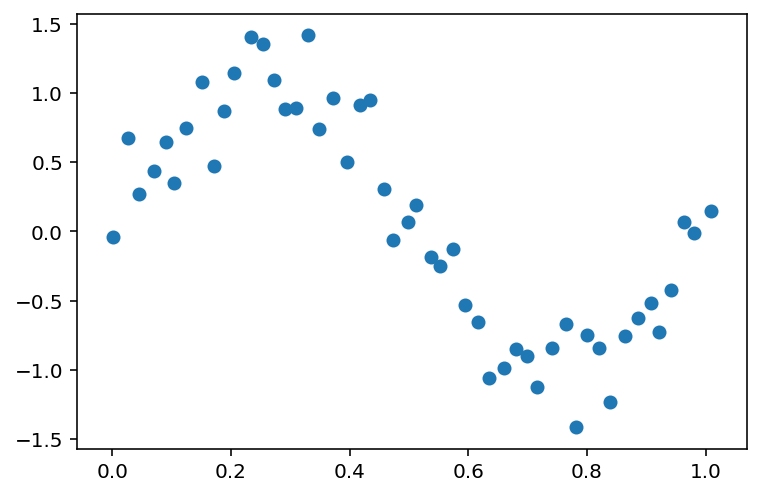

In [5]:
plt.scatter(X, y)

## Radial Basis Function Kernel

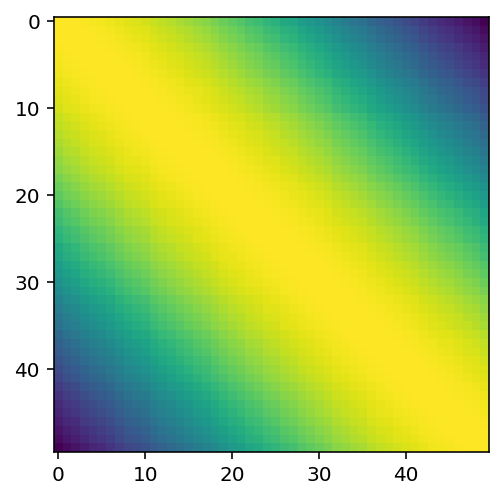

In [6]:
Phi = np.exp(-(X[np.newaxis, :] - X[:, np.newaxis]) ** 2)
plt.imshow(Phi)

In [7]:
seed(1643)
alpha = np.abs(randn(Phi.shape[1]) * 0.5)
beta, *_ = np.abs(randn(1)) * 0.5

In [8]:
A = np.identity(len(alpha)) * alpha
Sigma = np.linalg.inv(A + beta * Phi.T @ Phi)
m = beta * Sigma @ Phi.T @ y[:, np.newaxis]

mvn = multivariate_normal(mean=m.ravel(), cov=Sigma)

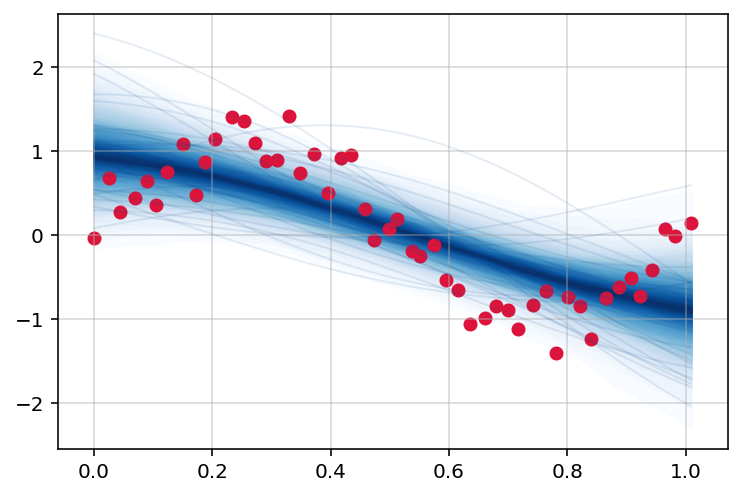

In [9]:
fig, ax = plt.subplots(1, 1)
plot_gp_dist(ax, (Phi @ mvn.rvs(500).T).T, X, palette="Blues")
ax.scatter(X, y, c="crimson")
ax.grid(alpha=0.5)

## Polynomial feature matrix

In [10]:
poly = PolynomialFeatures(degree=5, include_bias=True)
Phi = poly.fit_transform(X[:, np.newaxis])

seed(3141)
alpha = np.abs(randn(Phi.shape[1]))
beta, *_ = randn(1) * 0.5


A = np.identity(len(alpha)) * alpha
Sigma = np.linalg.inv(A + beta * Phi.T @ Phi)
m = beta * Sigma @ Phi.T @ y[:, np.newaxis]

mvn = multivariate_normal(mean=m.ravel(), cov=Sigma)

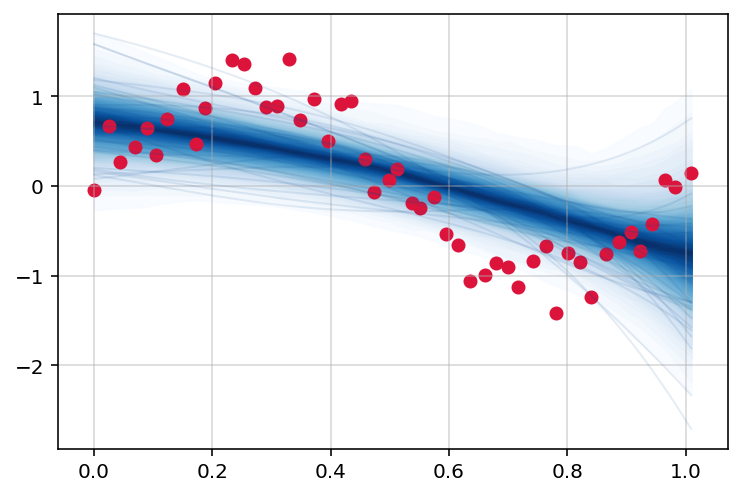

In [11]:
fig, ax = plt.subplots(1, 1)
plot_gp_dist(ax, (Phi @ mvn.rvs(500).T).T, X, palette="Blues")
ax.scatter(X, y, c="crimson")
ax.grid(alpha=0.5)

### Implementing the Marginal Likelihood

As of now, the hyperparameters $\alpha$, $\beta$ where randonmly chosen, we will now make use of the log-marginal likelihood to find the hyperparameters that best represent the data

In [12]:
poly = PolynomialFeatures(degree=5, include_bias=True)
Phi = poly.fit_transform(X[:, np.newaxis])

seed(314)
alpha = np.clip(np.abs(randn(Phi.shape[1])), 0, 0.8)
beta, *_ = np.abs(randn(1) + 1)

In [13]:
N, _ = Phi.shape

alpha_hist = [alpha]
for _ in range(10):
    A = np.identity(len(alpha)) * alpha
    # Inverse using the Cholesky decomposition
    L = np.linalg.cholesky(A + beta * Phi.T @ Phi)
    Sigma = np.linalg.inv(L).T @ np.linalg.inv(L)
    m = beta * Sigma @ Phi.T @ y[:, np.newaxis]
    gamma = 1 - alpha * np.diag(Sigma)

    new_alpha = gamma / m.ravel() ** 2
    new_beta = (N - gamma.sum()) / (np.linalg.norm(y[:, np.newaxis] - Phi @ m) ** 2)
    

    alpha = new_alpha
    beta = new_beta
    
    alpha_hist.append(alpha)

In [14]:
alpha

array([2388.381,    0.012,    0.002,    0.01 ,    0.083,    0.033])

In [15]:
np.linalg.eigvals(Sigma)

array([39.68 ,  4.219,  1.142,  0.045,  0.001,  0.004])

Iterating over the reestimating equations

$$
    \alpha_i = \frac{\gamma_i}{m_i^2}\\
$$
$$
    \frac{1}{\beta} = \frac{||\bf{t} - \Phi\bf{m}||^2}{N - \sum_m \gamma_m}
$$

result to be unsteady.

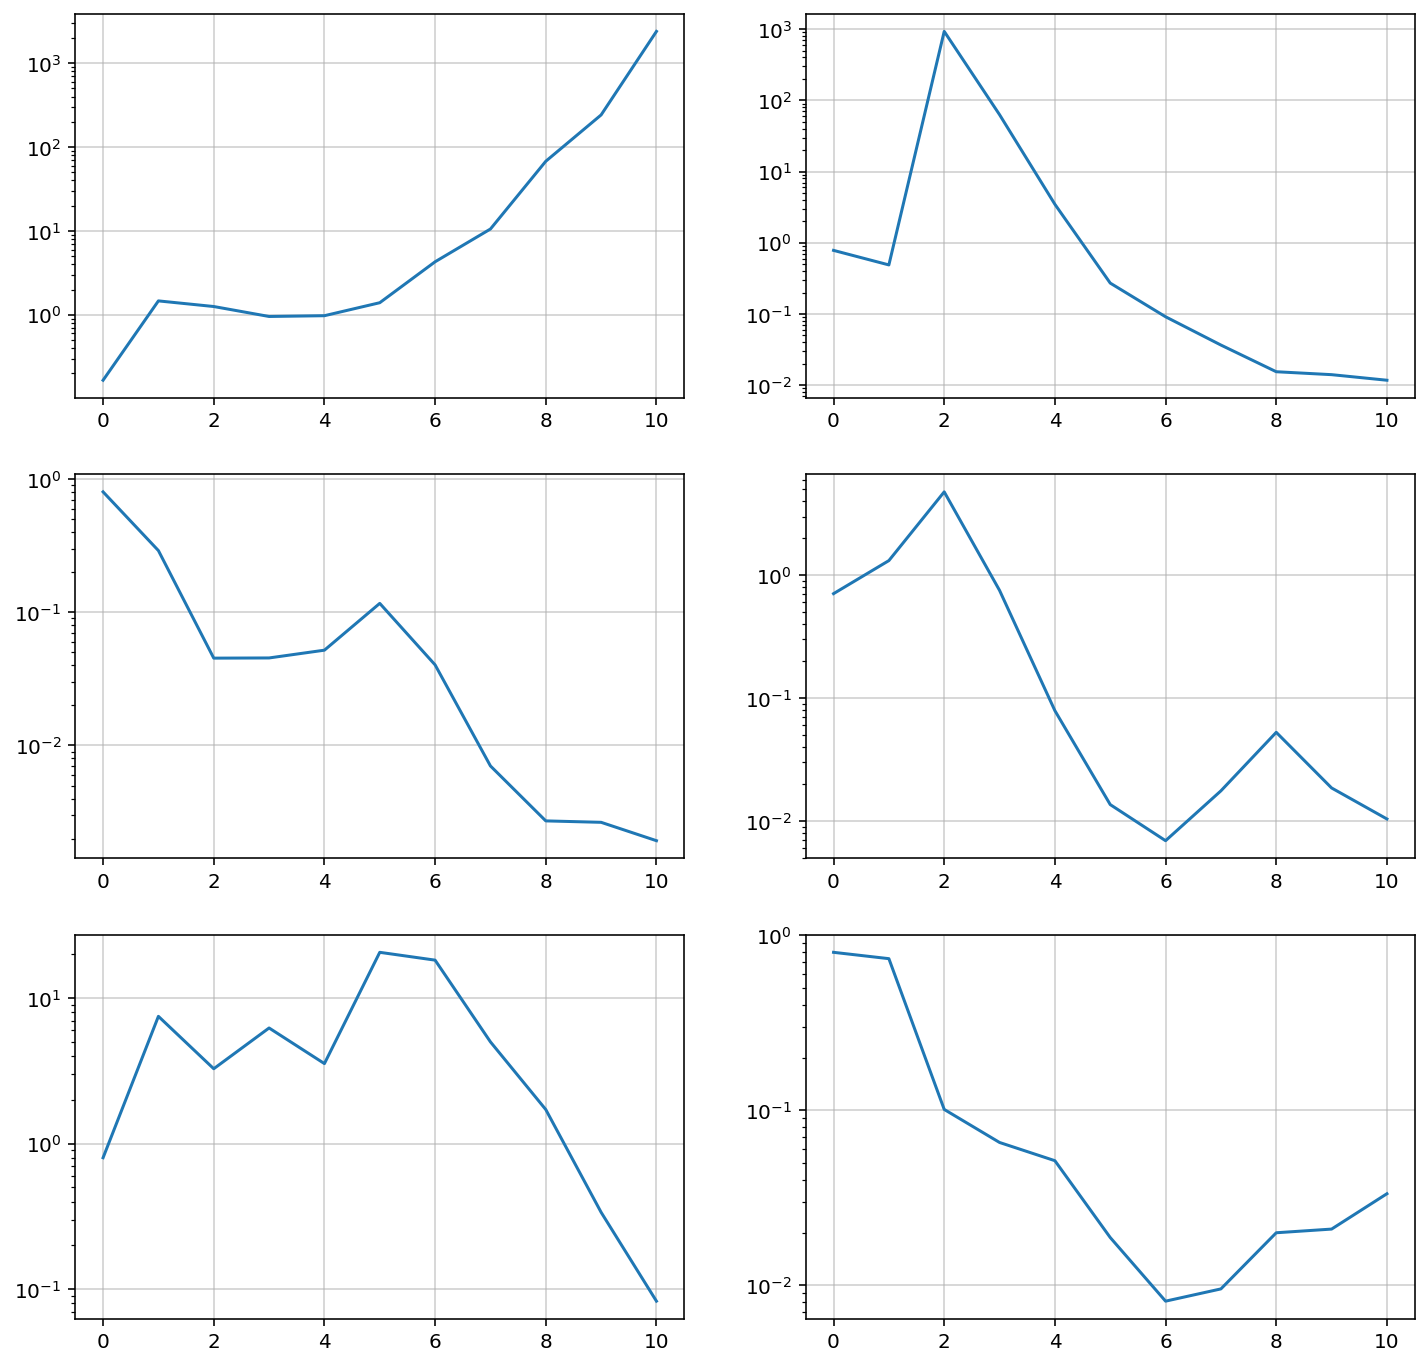

In [16]:
alpha_hist = np.r_[alpha_hist]
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
for axi, hist in zip(ax.ravel(), alpha_hist.T):
    axi.plot(hist)
    axi.set_yscale("log")
    axi.grid(alpha=0.6)

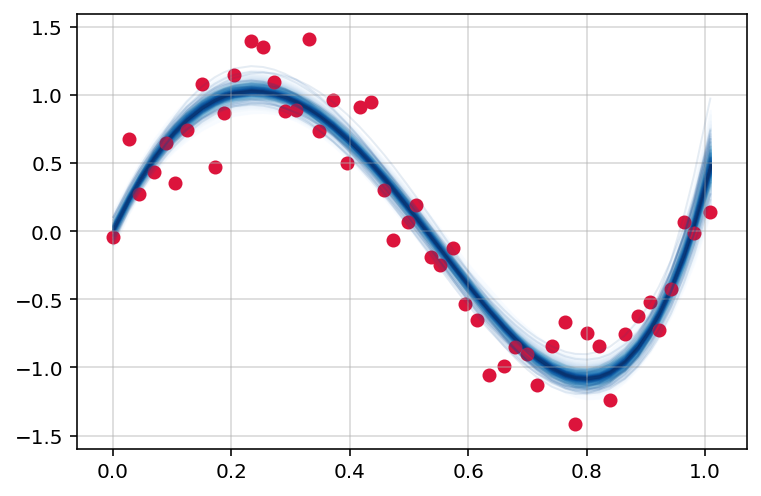

In [17]:
mvn = multivariate_normal(mean=m.ravel(), cov=Sigma)

fig, ax = plt.subplots(1, 1)
plot_gp_dist(ax, (Phi @ mvn.rvs(500).T).T, X, palette="Blues")
ax.scatter(X, y, c="crimson")
ax.grid(alpha=0.5)

### Sequential Sparse Bayesian Learning Algorithm


In [21]:
poly = PolynomialFeatures(degree=5, include_bias=True)
Phi = poly.fit_transform(X[:, np.newaxis])

In [112]:
N, M = Phi.shape

In [113]:
beta, alpha_i = np.abs(randn(2))
A = np.diag([np.inf] * M)
A[0, 0] = alpha_i

Sigma = np.linalg.inv(A + beta * Phi.T @ Phi)
m = beta * Sigma @ Phi.T @ y[:, np.newaxis]

In [118]:
i = np.random.randint(low=0, high=M-1)
i = 0

In [119]:
vPhi = Sigma[:, [i]]

In [120]:
Phi_less_i = np.delete(Phi, i, axis=1)
A_less_i = np.diag(np.delete(np.diag(A), i))
C_less_i = 1 / beta + Phi_less_i @ np.linalg.inv(A_less_i) @ Phi_less_i.T

In [121]:
C_less_i

array([[0.906, 0.906, 0.906, ..., 0.906, 0.906, 0.906],
       [0.906, 0.906, 0.906, ..., 0.906, 0.906, 0.906],
       [0.906, 0.906, 0.906, ..., 0.906, 0.906, 0.906],
       ...,
       [0.906, 0.906, 0.906, ..., 0.906, 0.906, 0.906],
       [0.906, 0.906, 0.906, ..., 0.906, 0.906, 0.906],
       [0.906, 0.906, 0.906, ..., 0.906, 0.906, 0.906]])

In [122]:
np.linalg.det(C_less_i)

0.0